In [1]:
# Loading the Pallas module, Numpy and Matplotlib
import pallas_trace as pallas
import numpy as np
import matplotlib.pyplot as plt


trace_name = "amg.4.16_trace"

In [2]:
%%time
# Downloading a trace from a trusted source and decompressing it
from urllib.request import urlretrieve
import tarfile
urlretrieve(f"http://stark2.int-evry.fr/traces/pallas_traces/ABI_{pallas.get_ABI()}/{trace_name}.tgz", f"{trace_name}.tgz")
with tarfile.open(f"{trace_name}.tgz") as tarfile:
    tarfile.extractall(".")


<timed exec>:6: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.


CPU times: user 288 ms, sys: 208 ms, total: 496 ms
Wall time: 761 ms


In [2]:
%%time
if not trace_name.endswith(".pallas"):
    trace_name += "/eztrace_log.pallas"

trace = pallas.open_trace(trace_name)
# Checking out general information about the trace
print(f"Trace is located in {trace.dir_name}/{trace.trace_name}")
# This loads the archives
print(f"Trace contains {len(trace.archives)} archives")
# This loads the threads
print(f"Trace contains {sum([len(a.threads) for a in trace.archives])} threads")


Trace is located in /home/khatharsis/Documents/Benchmarks/software/src/pallas/docs/amg.4.16_trace/eztrace_log.pallas
Trace contains 4 archives
Trace contains 64 threads
CPU times: user 11.2 ms, sys: 6.88 ms, total: 18.1 ms
Wall time: 17.9 ms


[P0T0] Pallas warning in pallas_open_trace (/home/khatharsis/Documents/Benchmarks/software/src/pallas/libraries/pallas/src/pallas_storage.cpp:1723): This trace uses Pallas ABI version 16, which is compatible with current version 17
[P0T0] Pallas warning in readMetadata (/home/khatharsis/Documents/Benchmarks/software/src/pallas/libraries/pallas/src/pallas_storage.cpp:1368): Could not read Thread metadata, ABI too low: 16 < 17


In [10]:
%%time
# Manually
def print_pallas_object(obj: pallas.Sequence| pallas.Loop | pallas.Event, index: int):
    match type(obj):
        case pallas.Sequence:
            print(f"{obj.timestamps[index]/1e9}\t{obj.guessName()}")
#        case pallas.Loop:
#            print(f"\tLoop {obj.id}")
        case pallas.Event:
            print(f"{obj.timestamps[index]/1e9}\t{obj.guessName()}")

def print_sequence(s: pallas.Sequence, counter: dict):
    for temp in s.content:
        if temp.id not in counter:
            counter[temp.id] = 0
        print_pallas_object(temp, counter[temp.id])
        counter[temp.id] +=1
        match type(temp):
            case pallas.Sequence:
                print_sequence(temp, counter)
            case pallas.Loop:
                for loop in range(temp.nb_iterations):
                    if temp.sequence.id not in counter:
                        counter[temp.sequence.id] = 0
                    print_pallas_object(temp.sequence, counter[temp.sequence.id])
                    print_sequence(temp.sequence, counter)
                    counter[temp.sequence.id] += 1

def print_thread(thread: pallas.Thread):
    counter = {}
    print_sequence(thread.sequences[0], counter)
                

print_thread(trace.archives[0].threads[0])
print("Done")

1.75545697	thread
1.75545697	E0
1.755967423	MPI_Bcast
1.755967423	E1
1.755985104	E2
1.756024485	E3
1.756052125	E4
1.756142017	MPI_Bcast
1.756142017	E1
1.756143288	E2
1.756154448	E5
1.756159368	E4
1.75624758	pthread_create
1.75624758	E6
1.756374553	E7
1.756388554	pthread_create
1.756388554	E6
1.756441535	E7
1.756463716	pthread_create
1.756463716	E6
1.756512207	E7
1.756520307	pthread_create
1.756520307	E6
1.756570808	E7
1.756577238	pthread_create
1.756577238	E6
1.75664755	E7
1.75665541	pthread_create
1.75665541	E6
1.756702922	E7
1.756708172	pthread_create
1.756708172	E6
1.756754643	E7
1.756760613	pthread_create
1.756760613	E6
1.757144953	E7
1.757156263	pthread_create
1.757156263	E6
1.757213054	E7
1.757220255	pthread_create
1.757220255	E6
1.757328717	E7
1.757340308	pthread_create
1.757340308	E6
1.757543153	E7
1.757554823	pthread_create
1.757554823	E6
1.757612815	E7
1.757618625	pthread_create
1.757618625	E6
1.757725237	E7
1.757732858	pthread_create
1.757732858	E6
1.75783382	E7
1.75784099	p

In [4]:
%%time
# Or using the built-in iterator
def print_thread(thread: pallas.Thread):
    for (token, index) in thread:
        print_pallas_object(token, index)

print_thread(trace.archives[0].threads[0])
print("Done ! It's definitely faster.")

Done ! It's definitely faster.
CPU times: user 106 ms, sys: 0 ns, total: 106 ms
Wall time: 105 ms


CPU times: user 51.3 ms, sys: 6.48 ms, total: 57.7 ms
Wall time: 57.1 ms


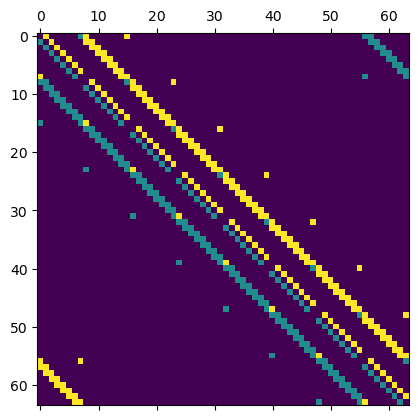

In [26]:
%%time
# Creating a communication matrix
matrix = np.zeros((len(trace.archives), len(trace.archives)))

for sender, archive in enumerate(trace.archives):
    for thread in archive.threads:
        for event in thread.get_events_from_record(pallas.Record.MPI_ISEND):
            data = event.data
            matrix[sender][data['receiver']] += data['msgLength']

plt.matshow(matrix)

S0	Sequence_0	48.75305308	48.75305308	48.75305308	1
S1	MPI_Comm_dup	0.000157332	0.002357128	0.00125723	2
S2	mpi_bcast_	2.16e-06	0.000119776	3.9902e-05	4
S3	mpi_bcast_	6.18e-06	6.18e-06	6.18e-06	1
S4	mpi_bcast_	5.392e-06	5.392e-06	5.392e-06	1
S5	mpi_irecv_	1.114e-05	8.8124e-05	2.0297e-05	201
S6	mpi_irecv_	1.868e-06	8.5104e-05	4.471e-06	201
S7	mpi_irecv_	1.6e-06	5.6104e-05	4.595e-06	201
S8	mpi_irecv_	2.592e-06	1.9372e-05	4.702e-06	201
S9	mpi_irecv_	1.208e-06	4.4652e-05	3.611e-06	201
S10	mpi_irecv_	1.908e-06	2.524e-05	3.68e-06	201
S11	mpi_isend_	6.42e-06	3.5692e-05	1.2836e-05	201
S12	mpi_isend_	3.572e-06	1.826e-05	6.658e-06	201
S13	mpi_isend_	2.592e-06	1.1728e-05	5.584e-06	201
S14	mpi_isend_	2.692e-06	8.692e-06	5.017e-06	201
S15	mpi_isend_	2.688e-06	0.000181224	6.385e-06	201
S16	mpi_isend_	3.032e-06	7.3592e-05	5.483e-06	201
S17	mpi_waitall_	0.004213872	0.009983292	0.007709838	201
S18	mpi_isend_	1.9852e-05	0.000121332	3.7946e-05	201
S19	mpi_irecv_	8.4e-07	0.000154728	6.126e-06	8442
S20	mpi

(array([7294.,  164.,   80.,  158.,  316.,   22.,   10.,   11.,   17.,
         370.]),
 array([0.00000000e+00, 1.84467441e+09, 3.68934881e+09, 5.53402322e+09,
        7.37869763e+09, 9.22337204e+09, 1.10680464e+10, 1.29127209e+10,
        1.47573953e+10, 1.66020697e+10, 1.84467441e+10]),
 <BarContainer object of 10 artists>)

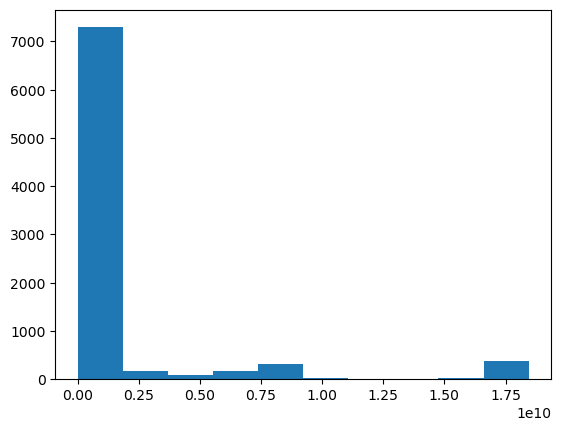

In [4]:
%%time
# Plotting an histogram to see the time distribution of a certain sequence
main_thread = trace.archives[0].threads[0]
for s in main_thread.sequences:
    print(f"{s.id}\t{s.guessName()}\t{s.min_duration / 1e9}\t{s.max_duration/1e9}\t{s.mean_duration/1e9}\t{s.n_iterations}")


selected_sequence = main_thread.sequences[20]
plt.hist(selected_sequence.durations.as_numpy_array() / 1e9)